# Pipeline Notebook - Part 3

This notebook serves as the **main orchestrator** for training and evaluating different neural network architectures, including:

- **Fully connected Deep AutoEncoder (fcDAE)**
- **Deep Convolutional AutoEncoder (DCAE)**

**Project Structure**  
The notebook integrates several Python modules for a modular and structured workflow:

- `libraries_utils.py` – Loads required libraries.  
- `code_methodo_2.py` – Defines **fcDAE**, **DCAE** architectures, along with other utilities for training neural networks.   
- `data_loader.py` – Handles data loading and preprocessing.  
- `functions_utils_for_nn.py` – Implements generators, training loops and inference functions.  
- `bootstrap_performances.py`, `regression_roc_auc.py`, `code_show_result.py` – Computes evaluation metrics for performance analysis.  

**Workflow**

1.Define hyperparameters and model configurations.  
2.Load and preprocess the dataset.  
3.Train the selected neural network model.  
4.Evaluate performance using predefined metrics.  
5.Visualize results and insights.  

This notebook ensures a structured and reproducible workflow for training and evaluating deep learning models on temporal and sequential data.

## Import Modules

In [1]:
#Use sys.getsizeof to get the size of an object, in bytes.
import sys
from sys import getsizeof

#%whos ou who -> to view defined variables
#getsizeof(tr_data) -> to see the variable size in number of bytes

import warnings
warnings.filterwarnings("ignore")

In [2]:
from libraries_utils import *
from code_methodo_2 import *
from bootstrap_performances import *
from data_loader import *
from regression_roc_auc import *
from functions_utils_for_nn import * # check avec cette fonction sur les anophèle âge... plus tard -> fichier importé grâce à code_methodo.py car import dans le fichier
from code_show_result import *

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f57571ae9b0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
2023-10-10 23:44:53.620085: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 23:44:53.620132: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 23:44:53.620161: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 23:44:53.627475: I tensorflow/core/platf

TensorFlow version:  2.14.0

Packages:
	keras.backend as K
	tensorflow.keras.layers import Layer
	keras import initializers, regularizers, constraints
    numpy as np

Functions:
    remove_files_in_folder
	ajout_colonne_anatomie_3_classes
	ajout_colonne_anatomie
	fusionner_espece
	f1_metric
	recall_m
    precision_m
    f1_m
    convert_sparse_matrix_to_sparse_tensor
    nn_batch_generator
    batch_generator
    new_my_batch_generator_timestep
    new_my_batch_generator_for_test_timestep
    class Attention
    generate_class_weights
    transform_spectrogram
    class fm_cwt_transform_into_scalogramm
    class fm_transform_into_image
    compute_wavelet_features
    batch_generator_for_scalo_image
    batch_generator_for_scalo_image_test




## 🤚 Note for readers :

### 👉Notes on Results:
The results presented in this notebook may differ by **approximately 1%** from those reported in the article. This discrepancy arises because, in the article, the reported values were rounded up to the nearest decimal.

# Results Table Initialization and Global Variable Setup

In [3]:
VALIDATION_ACCURACY = []
VALIDATION_F1_SCORE = []
VALIDATION_LOSS = []

TEST_ACCURACY , TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION , TEST_F1_SCORE, TEST_CM, TEST_BOOTSTRAP, TEST_ROC_AUC, TEST_R2_SCORE = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_MAE, TEST_ACC_BY_CAT = collections.defaultdict(list), collections.defaultdict(list)

fold_var = 0


Stock_pred = []
Stock_target = []
Stock_index = []

In [4]:
len_sp = 5000 #global variable

# Autoencoders

In [6]:
#len_sp = 5000
def run_model_autoencoder(data_name, model_name, part_anat = None):
    
    if data_name == 'MABSC_coh_espece':
        data_name = 'MABSC_coh'
        type_data_name = 'Intensite_interp_4'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        feature_of_stratification = 'souche'
        colonne = 'Intensite smooth baseline als interp reduc 4'
        target = 'espece'
        number_class = 1
        EPOCH = 25
        BATCH = 1
        types = 'classification'

        start = timeit.default_timer()

        show_all_table_results = pd.DataFrame()
        

        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()
        
        
        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)
        
        spectra_encoded = essaie.model_predict_encoder(data_train, colonne)
        
        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)
        
        spectra_encoded_test = essaie.model_predict_encoder(data_test, colonne)
        
        essaie.clean_model_session()
        
        encoder = LabelEncoder()
        encoder.fit(list(data_train[target]))
        target_keep = encoder.transform(data_train[target])
        encoder.fit(list(data_test[target]))
        y_new_test = encoder.transform(data_test[target])

        target_keep = target_keep.astype('float32').reshape(-1,1)

        del data_train, data_test

        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time auto encoder of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")
        
        
        regs = {}
        regs['knn'] = {'reg':KNeighborsClassifier(),'name':'KNeighborsClassifier'}
        regs['xgb'] = {'reg':XGBClassifier(n_estimators=1000,random_state= 0),'name':'XGBClassifier'}
        regs['ext'] = {'reg':ExtraTreesClassifier(n_estimators=100,random_state= 0),'name':'ExtraTreesClassifier'}
        regs['rf'] = {'reg':RandomForestClassifier(n_estimators=1000,random_state= 0),'name':'RandomForestClassifier'}
        regs['gbt'] = {'reg':GradientBoostingClassifier(n_estimators=25,random_state=0),'name':'GradientBoostingClassifier'}
        regs['gnb'] = {'reg':GaussianNB(),'name':'GaussianNB'}
        regs['lgb'] = {'reg':LGBMClassifier(),'name':'LGBMClassifier'}
        regs['lda'] = {'reg':LinearDiscriminantAnalysis(),'name':'LinearDiscriminantAnalysis'}
        regs['qda'] = {'reg': QuadraticDiscriminantAnalysis(),'name':'QuadraticDiscriminantAnalysis'}
        regs['svc'] = {'reg': SVC(kernel="linear"),'name':'SupportVectorClassification'}


        preds = {}

        for key in regs:
            start = timeit.default_timer()
            print( "Algo ML : ", key)
            regs[key]['reg'].fit(spectra_encoded, target_keep)
            preds[key] = regs[key]['reg'].predict(spectra_encoded_test)

            stop = timeit.default_timer()

            print("***************************************************************************************")
    
            print('Time of {}: '.format(key), stop - start)
    
            print("***************************************************************************************")
    

            
            
        print('Résultats MABSC Especes #########################################################################################')

        types = 'classification'

        tableau_perf_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list),collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_all = collections.defaultdict(list)


        for ml in preds :
            print(ml)
            tableau_perf = performances(y_new_test, np.abs(preds[ml]), types, ml)
            bootstrap_collect = bootstrap_performances(y_new_test, np.abs(preds[ml]), types, ml)

            for el, el_update in zip(tableau_perf, tableau_perf_all):
                        el_update.update(el)

            bootstrap_collect_all.update(bootstrap_collect)

        
        TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_all
        TEST_BOOTSTRAP = bootstrap_collect_all
        df_res_all = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                             TEST_BOOTSTRAP, None, position = 0)

        show_all_table_results = pd.concat([show_all_table_results, df_res_all], axis=0)

        print('#################################################################################################################')

        del tr_data, y_tr_data, va_data, y_va_data,  tst_data, y_tst_data, spectra_encoded, spectra_encoded_test

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        return show_all_table_results
            
        
    
    elif data_name == 'MABSC_coh_resistance':
        data_name = 'MABSC_coh'
        type_data_name = 'Intensite_interp_4'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        data_train['resistance'] = data_train.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        data_test['resistance'] = data_test.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        feature_of_stratification = 'souche'
        colonne = 'Intensite smooth baseline als interp reduc 4'
        target = 'resistance'
        number_class = 1
        EPOCH = 25
        BATCH = 1
        types = 'classification'


        start = timeit.default_timer()

        show_all_table_results = pd.DataFrame()

        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()
        
        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)
        
        spectra_encoded = essaie.model_predict_encoder(data_train, colonne)
        
        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)
        
        spectra_encoded_test = essaie.model_predict_encoder(data_test, colonne)
        
        essaie.clean_model_session()

        encoder = LabelEncoder()
        encoder.fit(list(data_train[target]))
        target_keep = encoder.transform(data_train[target])
        encoder.fit(list(data_test[target]))
        y_new_test = encoder.transform(data_test[target])
        
        del data_train, data_test

        
        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time auto encoder of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")
        
        
        regs = {}
        regs['knn'] = {'reg':KNeighborsClassifier(),'name':'KNeighborsClassifier'}
        regs['xgb'] = {'reg':XGBClassifier(n_estimators=1000,random_state= 0),'name':'XGBClassifier'}
        regs['ext'] = {'reg':ExtraTreesClassifier(n_estimators=100,random_state= 0),'name':'ExtraTreesClassifier'}
        regs['rf'] = {'reg':RandomForestClassifier(n_estimators=1000,random_state= 0),'name':'RandomForestClassifier'}
        regs['gbt'] = {'reg':GradientBoostingClassifier(n_estimators=25,random_state=0),'name':'GradientBoostingClassifier'}
        regs['gnb'] = {'reg':GaussianNB(),'name':'GaussianNB'}
        regs['lgb'] = {'reg':LGBMClassifier(),'name':'LGBMClassifier'}
        regs['lda'] = {'reg':LinearDiscriminantAnalysis(),'name':'LinearDiscriminantAnalysis'}
        regs['qda'] = {'reg': QuadraticDiscriminantAnalysis(),'name':'QuadraticDiscriminantAnalysis'}
        regs['svc'] = {'reg': SVC(kernel="linear"),'name':'SupportVectorClassification'}

        preds = {}

        for key in regs:
            start = timeit.default_timer()
            print( "Algo ML : ", key)
            regs[key]['reg'].fit(spectra_encoded, target_keep)
            print(spectra_encoded_test.shape)
            preds[key] = regs[key]['reg'].predict(spectra_encoded_test)

            stop = timeit.default_timer()

            print("***************************************************************************************")
    
            print('Time of {}: '.format(key), stop - start)
    
            print("***************************************************************************************")
            
            
            
        print('Résultats MABSC Resistance #########################################################################################')

        types = 'classification'

        tableau_perf_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list),collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_all = collections.defaultdict(list)


        for ml in preds :
            print(ml)
            tableau_perf = performances(y_new_test, np.abs(preds[ml]), types, ml)
            bootstrap_collect = bootstrap_performances(y_new_test, np.abs(preds[ml]), types, ml)

            for el, el_update in zip(tableau_perf, tableau_perf_all):
                        el_update.update(el)

            bootstrap_collect_all.update(bootstrap_collect)

        
        TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_all
        TEST_BOOTSTRAP = bootstrap_collect_all
        df_res_all = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                             TEST_BOOTSTRAP, None, position = 0)

        show_all_table_results = pd.concat([show_all_table_results, df_res_all], axis=0)

        print('#################################################################################################################')

        del tr_data, y_tr_data, va_data, y_va_data,  tst_data, y_tst_data, spectra_encoded, spectra_encoded_test

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
            
        return show_all_table_results
    
    
    
    elif data_name == 'Anophele_age':
        type_data_name = 'Intensite_interp_4'
        data_train, test_pauline, test_noemie = more_data_uploading(data_name, type_data_name)
        del test_noemie


        data_train['regression'] = data_train.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        test_pauline['regression'] = test_pauline.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)

        data_train['Partie anatomique'] = data_train.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        test_pauline['Partie anatomique'] = test_pauline.apply (lambda row: ajout_colonne_anatomie(row), axis=1)

        feature_of_stratification = 'sous_fichier'
        colonne = 'Intensite smooth baseline als interp reduc 4'
        target = 'regression'
        number_class = 1
        EPOCH = 25
        BATCH = 1
        types = 'regression'
        
        
        show_all_table_results = pd.DataFrame()

        if part_anat == 'Pattes' :
            part_anatom = 'P'

        elif part_anat == 'Tete' :
            part_anatom = 'T'

        elif part_anat == 'Thorax':
            part_anatom = 'TH'

        else :
            raise ValueError("Part anat name unknown")

        
        train = data_train[data_train['Partie anatomique']==part_anatom]
        train = train.reset_index(drop=True)

        tst_pauline = test_pauline[test_pauline['Partie anatomique']==part_anatom]
        tst_pauline = tst_pauline.reset_index(drop=True)

        start = timeit.default_timer()


        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                      target, colonne, encode=False, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()


        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)

        spectra_encoded = essaie.model_predict_encoder(train, colonne)

        tst_data_pauline, y_tst_data_pauline = essaie.data_preparation_zero_shot_test(tst_pauline, len_sp, feature_of_stratification,
                                                      target, colonne, encode = False)

        y_new_test = tst_pauline[target].values

        spectra_encoded_test = essaie.model_predict_encoder(tst_pauline, colonne)

        essaie.clean_model_session()

        target_keep = train[target].values

        del train, tst_pauline

        #print('Target Train : ', target_keep)

        #print('Target Test : ', y_new_test)

        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time auto encoder of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")
    


        regs = {}
        regs['knn'] = {'reg':KNeighborsRegressor(weights='distance'),'name':'KNeighborsRegressor'}
        regs['xgb'] = {'reg':XGBRegressor(n_estimators=1000,random_state= 0),'name':'XGBRegressor'}
        regs['ext'] = {'reg':ExtraTreesRegressor(n_estimators=100,random_state= 0),'name':'ExtraTreesRegressor'}
        regs['rf'] = {'reg':RandomForestRegressor(n_estimators=1000,random_state= 0),'name':'RandomForestRegressor'}
        regs['gbt'] = {'reg':GradientBoostingRegressor(random_state=0),'name':'GradientBoostingRegressor'}
        #regs['gnb'] = {'reg':GaussianNB(),'name':'GaussianNB'}
        regs['lgb'] = {'reg':LGBMRegressor(),'name':'LGBMRegressor'}
        regs['lnr'] = {'reg':LinearRegression(),'name':'LinearRegressor'}
        #regs['lda'] = {'reg':LinearDiscriminantAnalysis(),'name':'LinearDiscriminantAnalysis'}
        #regs['qda'] = {'reg': QuadraticDiscriminantAnalysis(),'name':'QuadraticDiscriminantAnalysis'}
        #regs['svr'] = {'reg': SVR(kernel="linear"),'name':'SupportVectorRegressor'}

        preds = {}

        for key in regs:
            start = timeit.default_timer()
            print(key)
            regs[key]['reg'].fit(spectra_encoded, target_keep)
            preds[key] = regs[key]['reg'].predict(spectra_encoded_test)

            stop = timeit.default_timer()

            print("***************************************************************************************")
    
            print('Time of {}: '.format(key), stop - start)
    
            print("***************************************************************************************")



        print('Résultats Anophele Age : {} #########################################################################################'.format(part_anatom))

        types = 'regression'

        tableau_perf_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_all = collections.defaultdict(list)


        for ml in preds :
            print(ml)
            tableau_perf = performances(y_new_test, np.abs(preds[ml]), types, ml)
            bootstrap_collect = bootstrap_performances(y_new_test, np.abs(preds[ml]), types, ml)

            for el, el_update in zip(tableau_perf, tableau_perf_all):
                        el_update.update(el)

            bootstrap_collect_all.update(bootstrap_collect)

        TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE = tableau_perf_all
        TEST_BOOTSTRAP = bootstrap_collect_all
        df_res_all = show_table_results_regression(TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP, None, position = 0)

        show_all_table_results = pd.concat([show_all_table_results, df_res_all], axis=0)

        print('#################################################################################################################')



        del tr_data, y_tr_data, va_data, y_va_data, tst_data_pauline, y_tst_data_pauline, spectra_encoded, spectra_encoded_test

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
            
        return show_all_table_results
            
    
    elif data_name == 'Anophele_identif':
        type_data_name = 'Intensite_interp_4'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        
        data_train = data_train[~data_train.espece.isin(['Hybrides An. coluzzii-gambiae'])]
        data_test = data_test[~data_test.espece.isin(['Hybrides An. coluzzii-gambiae'])]
        
        feature_of_stratification = 'sous_fichier'
        colonne = 'Intensite smooth baseline als interp reduc 4'
        target = 'espece'
        number_class = 1
        EPOCH = 25
        BATCH = 1
        types = 'classification'

        show_all_table_results = pd.DataFrame()
        
        
        if part_anat == 'Pattes' :
            part_anatom = 'PATTES'

        elif part_anat == 'Tete' :
            part_anatom = 'TETE'

        elif part_anat == 'Thorax':
            part_anatom = 'THORAX'

        else :
            raise ValueError("Part anat name unknown")
            
            
        train = data_train[data_train['anatom']==part_anatom] 
        train = train.reset_index(drop=True)

        tst = data_test[data_test['anatom']==part_anatom] 
        tst = tst.reset_index(drop=True)


        start = timeit.default_timer()
        
        
        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                      target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()
    
    
        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)
    
        spectra_encoded = essaie.model_predict_encoder(train, colonne)
        
        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(tst, len_sp, feature_of_stratification,
                                                      target, colonne, encode = True)
    
        spectra_encoded_test = essaie.model_predict_encoder(tst, colonne)

        
        
        essaie.clean_model_session()

        encoder = LabelEncoder()
        encoder.fit(train[target])
        target_keep = encoder.transform(train[target])
        encoder.fit(list(tst[target]))
        y_new_test = encoder.transform(tst[target])


        del train, tst

        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time auto encoder of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")
    
    
    
        regs = {}
        regs['knn'] = {'reg':KNeighborsClassifier(),'name':'KNeighborsClassifier'}
        regs['xgb'] = {'reg':XGBClassifier(n_estimators=1000,random_state= 0),'name':'XGBClassifier'}
        regs['ext'] = {'reg':ExtraTreesClassifier(n_estimators=100,random_state= 0),'name':'ExtraTreesClassifier'}
        regs['rf'] = {'reg':RandomForestClassifier(n_estimators=1000,random_state= 0),'name':'RandomForestClassifier'}
        regs['gbt'] = {'reg':GradientBoostingClassifier(n_estimators=25,random_state=0),'name':'GradientBoostingClassifier'}
        regs['gnb'] = {'reg':GaussianNB(),'name':'GaussianNB'}
        regs['lgb'] = {'reg':LGBMClassifier(),'name':'LGBMClassifier'}
        regs['lda'] = {'reg':LinearDiscriminantAnalysis(),'name':'LinearDiscriminantAnalysis'}
        regs['qda'] = {'reg': QuadraticDiscriminantAnalysis(),'name':'QuadraticDiscriminantAnalysis'}
        regs['svc'] = {'reg': SVC(kernel="linear"),'name':'SupportVectorClassification'}


        preds = {}

        for key in regs:
            start = timeit.default_timer()
            regs[key]['reg'].fit(spectra_encoded, target_keep)
            print(key)
            preds[key] = regs[key]['reg'].predict(spectra_encoded_test)

            stop = timeit.default_timer()

            print("***************************************************************************************")
    
            print('Time of {}: '.format(key), stop - start)
    
            print("***************************************************************************************")
    



        print('Résultats Anophele Espece : {} #########################################################################################'.format(part_anatom))

        types = 'classification'

        tableau_perf_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list),collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_all = collections.defaultdict(list)


        for ml in preds :
            print(ml)
            tableau_perf = performances(y_new_test, np.abs(preds[ml]), types, ml)
            bootstrap_collect = bootstrap_performances(y_new_test, np.abs(preds[ml]), types, ml)

            for el, el_update in zip(tableau_perf, tableau_perf_all):
                        el_update.update(el)

            bootstrap_collect_all.update(bootstrap_collect)

        
        TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_all
        TEST_BOOTSTRAP = bootstrap_collect_all
        df_res_all = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                             TEST_BOOTSTRAP, None, position = 0)

        show_all_table_results = pd.concat([show_all_table_results, df_res_all], axis=0)

        print('#################################################################################################################')

        del tr_data, y_tr_data, va_data, y_va_data,  tst_data, y_tst_data, spectra_encoded, spectra_encoded_test

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        return show_all_table_results
        
    else :
        raise ValueError("Data name unknown")
    

## Deep Convolutional Auto Encoder

### MABS resistance detection

2023-10-10 22:25:59.414842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc24af14be0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [0, 2, 4, 5, 7, 8, 9, 11, 14, 16, 19, 21, 22, 23, 24, 25, 27, 28, 31, 3, 6, 10, 13, 15, 17, 30, 32] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Val label :  [18, 20, 26, 29, 1, 12] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 1, 1]
Train data dimensions: (648, 5000), (648, 1)
Validation data dimensions: (166, 5000), (166, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)   

2023-10-10 22:26:07.791221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 22:26:09.075379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc0c07d1450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 22:26:09.075420: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 22:26:09.081200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 22:26:09.180730: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


648/648 [==============================] - 18s 12ms/step - loss: 189913.7500 - val_loss: 127437.4453
Epoch 2/25
648/648 [==============================] - 7s 11ms/step - loss: 140631.7812 - val_loss: 109939.4453
Epoch 3/25
648/648 [==============================] - 7s 11ms/step - loss: 131791.0938 - val_loss: 108448.5938
Epoch 4/25
648/648 [==============================] - 7s 11ms/step - loss: 128802.9609 - val_loss: 107948.1328
Epoch 5/25
648/648 [==============================] - 7s 11ms/step - loss: 128028.5938 - val_loss: 108450.3984
Epoch 6/25
648/648 [==============================] - 8s 12ms/step - loss: 127233.5469 - val_loss: 107662.8516
Epoch 7/25
648/648 [==============================] - 7s 11ms/step - loss: 126614.4844 - val_loss: 108164.4609
Epoch 8/25
648/648 [==============================] - 7s 11ms/step - loss: 126467.4922 - val_loss: 108611.1953
Epoch 9/25
648/648 [==============================] - 7s 11ms/step - loss: 126952.4922 - val_loss: 106430.2266
Epoch 10/25

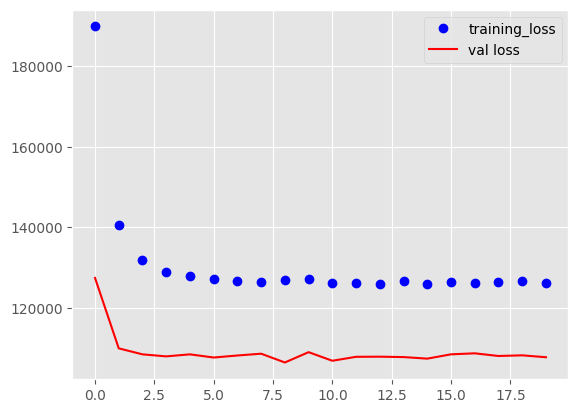

814/814 [==============================] - 1s 1ms/step
Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 5000), (187, 1)
187/187 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of MABSC_coh:  161.51848078600597
***************************************************************************************
Algo ML :  knn
(187, 497)
***************************************************************************************
Time of knn:  0.09686335502192378
***************************************************************************************
Algo ML :  xgb
(187, 497)
***************************************************************************************
Time of xgb:  6.131502760923468
***************************************************************************************
Algo ML :  ext
(187, 497)
************************************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc24b1022f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:05:41
	Energy:	0.011016202204 kWh
	CO2eq:	5.232696046918 g
	This is equivalent to:
	0.048676242297 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc24b101f00>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	4:44:13
	Energy:	0.550810110202 kWh
	CO2eq:	261.634802345884 g
	This is equivalent to:
	2.433812114845 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1581282_2023-10-10T222559Z_carbontracker_output.log
St

In [7]:
model_choice = 'deep_auto_encoder_conv'
Tables_regression_results_MABSC_coh_resistance = run_model_autoencoder('MABSC_coh_resistance', model_choice)

In [8]:
display(Tables_regression_results_MABSC_coh_resistance)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.71,0.78,0.88,0.89,0.89,0.81,0.88,0.62,0.74,0.78
,"[0.65,0.78]","[0.73,0.84]","[0.84,0.93]","[0.84,0.94]","[0.85,0.94]","[0.75,0.86]","[0.83,0.93]","[0.56,0.7]","[0.68,0.81]","[0.73,0.84]"
Test balanced accuracy,0.75,0.72,0.79,0.78,0.80,0.83,0.77,0.62,0.50,0.75
,"[0.68,0.81]","[0.64,0.8]","[0.72,0.86]","[0.71,0.85]","[0.73,0.88]","[0.78,0.89]","[0.7,0.85]","[0.54,0.71]","[0.5,0.5]","[0.68,0.83]"
Mean F1 score,0.68,0.71,0.82,0.83,0.84,0.78,0.81,0.58,0.42,0.73
,"[0.62,0.76]","[0.64,0.79]","[0.75,0.89]","[0.75,0.89]","[0.76,0.91]","[0.72,0.84]","[0.74,0.89]","[0.51,0.66]","[0.41,0.45]","[0.66,0.81]"
F1 score by categories,"[0.78, 0.6]","[0.86, 0.58]","[0.93, 0.73]","[0.93, 0.73]","[0.94, 0.75]","[0.86, 0.71]","[0.93, 0.7]","[0.72, 0.45]","[0.86, 0.0]","[0.85, 0.62]"
Mean precision,0.69,0.71,0.90,0.93,0.92,0.76,0.91,0.59,0.37,0.72
,"[0.64,0.75]","[0.63,0.79]","[0.85,0.95]","[0.91,0.96]","[0.88,0.96]","[0.71,0.83]","[0.87,0.95]","[0.53,0.66]","[0.34,0.4]","[0.66,0.79]"


### MABS subspecies identification 

2023-10-10 22:49:10.050739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f3580890520>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [0, 1, 7, 12, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 4, 5, 14, 16, 3, 6, 8, 9, 13, 15, 18] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Val label :  [11, 22, 23, 29, 2, 10] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 2, 2]
Train data dimensions: (680, 5000), (680, 1)
Validation data dimensions: (134, 5000), (134, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)   

2023-10-10 22:49:18.369042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 22:49:19.688332: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f33f488baa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 22:49:19.688371: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 22:49:19.694166: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 22:49:19.793086: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


680/680 [==============================] - 18s 12ms/step - loss: 148284.6875 - val_loss: 105868.6484
Epoch 2/25
680/680 [==============================] - 9s 14ms/step - loss: 132236.2031 - val_loss: 103352.5859
Epoch 3/25
680/680 [==============================] - 8s 11ms/step - loss: 129551.3203 - val_loss: 102694.8906
Epoch 4/25
680/680 [==============================] - 8s 12ms/step - loss: 128819.0703 - val_loss: 104436.0625
Epoch 5/25
680/680 [==============================] - 8s 12ms/step - loss: 128580.8438 - val_loss: 103538.8750
Epoch 6/25
680/680 [==============================] - 8s 11ms/step - loss: 127400.3516 - val_loss: 101574.7266
Epoch 7/25
680/680 [==============================] - 8s 11ms/step - loss: 127288.8594 - val_loss: 103322.0312
Epoch 8/25
680/680 [==============================] - 8s 11ms/step - loss: 127118.0156 - val_loss: 103776.2344
Epoch 9/25
680/680 [==============================] - 8s 11ms/step - loss: 127422.3750 - val_loss: 101323.1094
Epoch 10/25

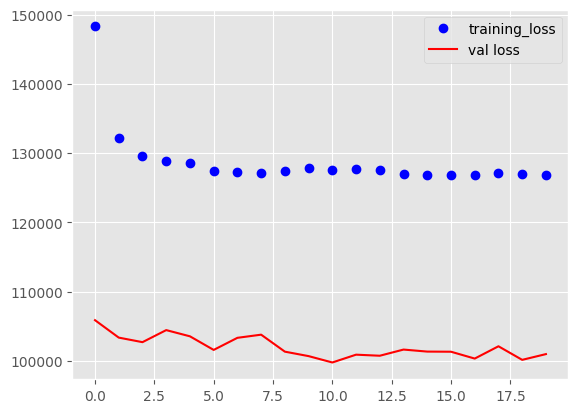

814/814 [==============================] - 1s 1ms/step
Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 5000), (187, 1)
187/187 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of MABSC_coh:  213.1647283739876
***************************************************************************************
Algo ML :  knn
***************************************************************************************
Time of knn:  0.09708561596926302
***************************************************************************************
Algo ML :  xgb
***************************************************************************************
Time of xgb:  8.964547788025811
***************************************************************************************
Algo ML :  ext
**********************************************************************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f34d058b610>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:07:16
	Energy:	0.013337579026 kWh
	CO2eq:	6.335350037384 g
	This is equivalent to:
	0.058933488720 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f34d0588190>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	6:03:14
	Energy:	0.666878951304 kWh
	CO2eq:	316.767501869184 g
	This is equivalent to:
	2.946674435992 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1585301_2023-10-10T224910Z_carbontracker_output.log
St

In [8]:
model_choice = 'deep_auto_encoder_conv'
Tables_regression_results_MABSC_coh_espece = run_model_autoencoder('MABSC_coh_espece', model_choice)

In [9]:
display(Tables_regression_results_MABSC_coh_espece)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.66,0.93,0.67,0.74,0.69,0.61,0.89,0.72,0.50,0.63
,"[0.6,0.73]","[0.9,0.97]","[0.6,0.74]","[0.68,0.81]","[0.63,0.76]","[0.55,0.68]","[0.86,0.94]","[0.66,0.79]","[0.44,0.58]","[0.57,0.71]"
Test balanced accuracy,0.58,0.93,0.56,0.66,0.68,0.50,0.87,0.70,0.33,0.51
,"[0.54,0.62]","[0.89,0.97]","[0.52,0.61]","[0.67,0.67]","[0.63,0.75]","[0.46,0.56]","[0.82,0.92]","[0.65,0.77]","[0.33,0.33]","[0.46,0.56]"
Mean F1 score,0.51,0.93,0.52,0.59,0.66,0.45,0.89,0.68,0.22,0.47
,"[0.46,0.55]","[0.89,0.97]","[0.47,0.57]","[0.58,0.62]","[0.6,0.75]","[0.41,0.51]","[0.85,0.94]","[0.61,0.76]","[0.2,0.24]","[0.42,0.52]"
F1 score by categories,"[0.77, 0.0, 0.77]","[0.94, 0.98, 0.88]","[0.76, 0.0, 0.81]","[0.81, 0.0, 0.99]","[0.71, 0.53, 0.77]","[0.72, 0.0, 0.66]","[0.91, 0.85, 0.92]","[0.76, 0.47, 0.84]","[0.67, 0.0, 0.0]","[0.74, 0.0, 0.68]"
Mean precision,0.45,0.93,0.52,0.55,0.77,0.44,0.93,0.73,0.16,0.50
,"[0.4,0.5]","[0.9,0.97]","[0.49,0.56]","[0.52,0.58]","[0.73,0.82]","[0.39,0.49]","[0.9,0.96]","[0.66,0.82]","[0.15,0.19]","[0.46,0.55]"


### Anopheles age : Legs

2023-10-10 22:57:40.381379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb8a222af50>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] size :  162
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

2023-10-10 22:57:48.895457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 22:57:50.304243: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb717db05d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 22:57:50.304284: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 22:57:50.310126: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 22:57:50.409495: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


647/647 [==============================] - 18s 12ms/step - loss: 50203.5938 - val_loss: 54249.2344
Epoch 2/25
647/647 [==============================] - 8s 12ms/step - loss: 50203.5898 - val_loss: 54249.2344
Epoch 3/25
647/647 [==============================] - 8s 12ms/step - loss: 50203.5898 - val_loss: 54249.2344
Epoch 4/25
647/647 [==============================] - 7s 11ms/step - loss: 50203.5703 - val_loss: 54249.2344
Epoch 5/25
647/647 [==============================] - 7s 11ms/step - loss: 50203.5859 - val_loss: 54249.2344
Epoch 6/25
647/647 [==============================] - 7s 11ms/step - loss: 50203.5781 - val_loss: 54249.2344
Epoch 7/25
647/647 [==============================] - 7s 11ms/step - loss: 50203.5625 - val_loss: 54249.2344
Epoch 8/25
647/647 [==============================] - 7s 11ms/step - loss: 50203.5938 - val_loss: 54249.2344
Epoch 9/25
647/647 [==============================] - 7s 11ms/step - loss: 50203.5781 - val_loss: 54249.2344
Epoch 10/25
647/647 [========

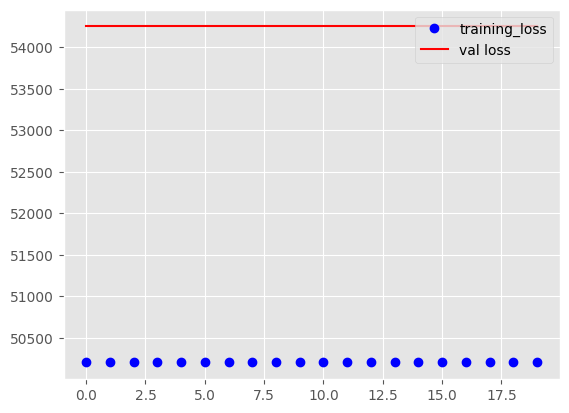

806/806 [==============================] - 1s 1ms/step
Non encode target
Test label :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] size :  36
Y test clone/non clone :  [ 0  0  3  3  3  3  3  6  6  8  8  8  8  8 10 10 10 10 15 17 17 17 17 17
 17 17 20 20 20 20 24 24 24 24 24 28]
Test data dimensions: (144, 5000), (144, 1)
144/144 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_age:  162.51211064402014
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.09954287600703537
***************************************************************************************
xgb
***************************************************************************************
Time of xgb:  6.90

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb8a21f8ca0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:05:32
	Energy:	0.007880433625 kWh
	CO2eq:	3.743205971880 g
	This is equivalent to:
	0.034820520669 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb8a21f9960>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	4:36:35
	Energy:	0.394021681251 kWh
	CO2eq:	187.160298594024 g
	This is equivalent to:
	1.741026033433 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1586730_2023-10-10T225740Z_carbontracker_output.log
St

In [6]:
model_choice = 'deep_auto_encoder_conv'
Tables_regression_results_Ano_age = run_model_autoencoder('Anophele_age', model_choice, part_anat = 'Pattes')

In [7]:
display(Tables_regression_results_Ano_age)

,knn,xgb,ext,rf,gbt,lgb,lnr
Metrics,,,,,,,
Test MAE,3.28,3.30,2.81,2.54,2.58,2.47,9.79
,"[2.87,3.72]","[2.86,3.76]","[2.5,3.15]","[2.14,2.97]","[2.22,2.93]","[2.1,2.82]","[7.84,12.24]"
Roc AUC score,0.87,0.85,0.92,0.90,0.90,0.91,0.73
,"[0.83,0.9]","[0.81,0.89]","[0.9,0.95]","[0.86,0.93]","[0.87,0.93]","[0.88,0.94]","[0.68,0.77]"
R2 score,0.71,0.68,0.81,0.78,0.81,0.82,-3.52


### Anopheles age : Head

2023-10-10 23:04:54.415715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9a4f53bdc0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 75, 76, 77, 78, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 120, 121, 123, 124, 125, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 144, 145, 146, 147, 149, 151, 152, 153, 155, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182] size :  147
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1

2023-10-10 23:05:02.819416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 23:05:04.100180: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f98c83eb1a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 23:05:04.100219: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 23:05:04.106328: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 23:05:04.205616: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


583/583 [==============================] - 17s 13ms/step - loss: 29843.6133 - val_loss: 23898.0645
Epoch 2/25
583/583 [==============================] - 7s 12ms/step - loss: 29843.6289 - val_loss: 23898.0645
Epoch 3/25
583/583 [==============================] - 7s 12ms/step - loss: 29843.6270 - val_loss: 23898.0645
Epoch 4/25
583/583 [==============================] - 7s 12ms/step - loss: 29843.6230 - val_loss: 23898.0645
Epoch 5/25
583/583 [==============================] - 7s 12ms/step - loss: 29843.6094 - val_loss: 23898.0645
Epoch 6/25
583/583 [==============================] - 7s 11ms/step - loss: 29843.6055 - val_loss: 23898.0645
Epoch 7/25
583/583 [==============================] - 7s 12ms/step - loss: 29843.6328 - val_loss: 23898.0645
Epoch 8/25
583/583 [==============================] - 7s 12ms/step - loss: 29843.6230 - val_loss: 23898.0645
Epoch 9/25
583/583 [==============================] - 7s 12ms/step - loss: 29843.6152 - val_loss: 23898.0645
Epoch 10/25
583/583 [========

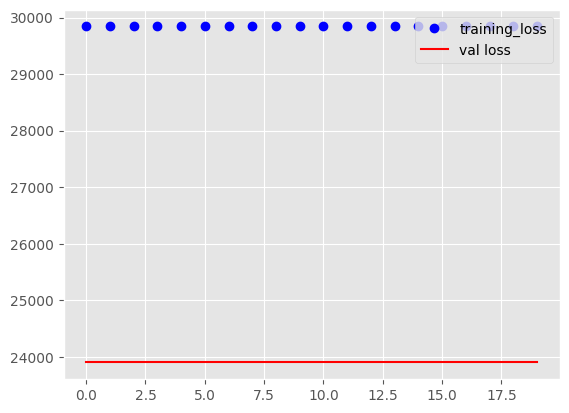

727/727 [==============================] - 1s 1ms/step
Non encode target
Test label :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31] size :  32
Y test clone/non clone :  [ 0  0  3  3  3  3  3  6  6  8  8  8  8  8 10 15 15 17 17 17 17 17 20 20
 20 20 24 24 24 24 28 28]
Test data dimensions: (124, 5000), (124, 1)
124/124 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_age:  149.24789201002568
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.09720108704641461
***************************************************************************************
xgb
***************************************************************************************
Time of xgb:  11.293715305044316
*********

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f99404abfd0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:06:38
	Energy:	0.008469892145 kWh
	CO2eq:	4.023198768784 g
	This is equivalent to:
	0.037425104826 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f994196ce20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	5:31:28
	Energy:	0.423494607240 kWh
	CO2eq:	201.159938439183 g
	This is equivalent to:
	1.871255241295 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1588023_2023-10-10T230454Z_carbontracker_output.log
St

In [7]:
model_choice = 'deep_auto_encoder_conv'
Tables_regression_results_Ano_age = run_model_autoencoder('Anophele_age', model_choice, part_anat = 'Tete')

In [8]:
display(Tables_regression_results_Ano_age)

,knn,xgb,ext,rf,gbt,lgb,lnr
Metrics,,,,,,,
Test MAE,3.00,4.61,3.56,3.72,3.10,3.16,7.89
,"[2.47,3.54]","[4.1,5.14]","[3.18,4.02]","[3.31,4.18]","[2.72,3.52]","[2.77,3.57]","[6.77,9.09]"
Roc AUC score,0.89,0.82,0.90,0.89,0.90,0.90,0.67
,"[0.85,0.92]","[0.78,0.86]","[0.88,0.93]","[0.85,0.92]","[0.88,0.93]","[0.87,0.93]","[0.62,0.73]"
R2 score,0.75,0.57,0.74,0.71,0.79,0.78,-0.46


### Anopheles age : Thorax

2023-10-10 23:13:55.112484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe13e1bf400>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 78, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 103, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 133, 134, 135, 137, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 152, 153, 155, 156, 157, 159, 160, 161, 163, 164, 165, 166, 167, 169, 170, 172, 173, 174, 175, 176, 177, 178] size :  144
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 1

2023-10-10 23:14:03.596089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 23:14:04.877184: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdfb04c35a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 23:14:04.877225: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 23:14:04.882961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 23:14:04.982520: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


560/560 [==============================] - 17s 13ms/step - loss: 65380.4297 - val_loss: 41966.9805
Epoch 2/25
560/560 [==============================] - 7s 12ms/step - loss: 45635.2617 - val_loss: 22864.6777
Epoch 3/25
560/560 [==============================] - 6s 11ms/step - loss: 35265.1289 - val_loss: 21968.2305
Epoch 4/25
560/560 [==============================] - 7s 12ms/step - loss: 34101.8672 - val_loss: 21057.7949
Epoch 5/25
560/560 [==============================] - 6s 12ms/step - loss: 33722.5898 - val_loss: 20992.3574
Epoch 6/25
560/560 [==============================] - 6s 11ms/step - loss: 33232.3594 - val_loss: 20747.1406
Epoch 7/25
560/560 [==============================] - 7s 12ms/step - loss: 33171.1719 - val_loss: 20730.8320
Epoch 8/25
560/560 [==============================] - 6s 12ms/step - loss: 33146.1680 - val_loss: 20691.4004
Epoch 9/25
560/560 [==============================] - 6s 12ms/step - loss: 33004.6836 - val_loss: 20577.1309
Epoch 10/25
560/560 [========

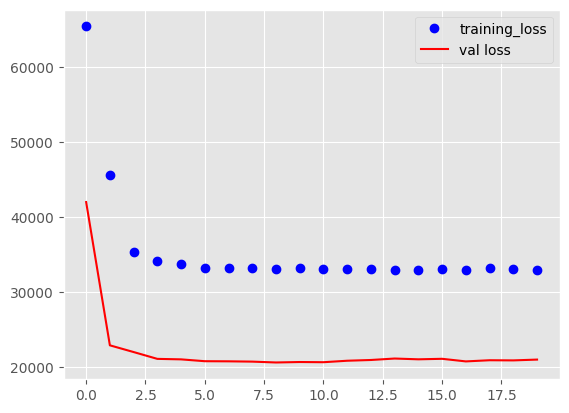

689/689 [==============================] - 1s 1ms/step
Non encode target
Test label :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] size :  31
Y test clone/non clone :  [ 0  0  3  3  3  3  3  6  6  6  8  8 10 10 15 15 15 17 17 17 20 20 20 20
 24 24 24 24 24 28 28]
Test data dimensions: (117, 5000), (117, 1)
117/117 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_age:  143.84839195397217
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.10003929806407541
***************************************************************************************
xgb
***************************************************************************************
Time of xgb:  11.486065309029073
***************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe038118070>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:06:15
	Energy:	0.008411069353 kWh
	CO2eq:	3.995257942855 g
	This is equivalent to:
	0.037165190166 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe038119510>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	5:12:50
	Energy:	0.420553467669 kWh
	CO2eq:	199.762897142735 g
	This is equivalent to:
	1.858259508305 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1589511_2023-10-10T231355Z_carbontracker_output.log
St

In [8]:
model_choice = 'deep_auto_encoder_conv'
Tables_regression_results_Ano_age = run_model_autoencoder('Anophele_age', model_choice, part_anat = 'Thorax')

In [9]:
display(Tables_regression_results_Ano_age)

,knn,xgb,ext,rf,gbt,lgb,lnr
Metrics,,,,,,,
Test MAE,2.84,3.25,2.44,2.79,2.60,2.52,16.23
,"[2.43,3.23]","[2.64,3.96]","[2.12,2.81]","[2.29,3.35]","[2.16,3.09]","[2.07,3.05]","[12.68,20.06]"
Roc AUC score,0.90,0.87,0.94,0.90,0.91,0.91,0.66
,"[0.88,0.93]","[0.83,0.92]","[0.92,0.97]","[0.87,0.94]","[0.89,0.95]","[0.88,0.95]","[0.6,0.72]"
R2 score,0.82,0.67,0.87,0.79,0.82,0.82,-8.10


### Anopheles species identification : Legs

2023-10-10 23:21:56.963016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2d5e208a90>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 114, 115, 116, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 193, 195, 196, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 48, 49, 50, 51, 52, 53, 55, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 117, 118, 119, 120, 121, 122, 123, 124, 57, 58, 0, 59, 60, 61, 62, 66, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 153, 154] size :  169
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

2023-10-10 23:22:05.435519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 23:22:06.710050: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2bd4af5f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 23:22:06.710089: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 23:22:06.715922: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 23:22:06.815096: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


825/825 [==============================] - 21s 13ms/step - loss: 172665.2969 - val_loss: 118422.9609
Epoch 2/25
825/825 [==============================] - 10s 12ms/step - loss: 129259.8203 - val_loss: 111343.6953
Epoch 3/25
825/825 [==============================] - 10s 12ms/step - loss: 123328.0078 - val_loss: 107167.8281
Epoch 4/25
825/825 [==============================] - 10s 12ms/step - loss: 120169.7734 - val_loss: 107350.1562
Epoch 5/25
825/825 [==============================] - 10s 12ms/step - loss: 117996.4766 - val_loss: 106442.8047
Epoch 6/25
825/825 [==============================] - 10s 12ms/step - loss: 118066.7656 - val_loss: 105342.9219
Epoch 7/25
825/825 [==============================] - 10s 12ms/step - loss: 117454.6016 - val_loss: 105582.4141
Epoch 8/25
825/825 [==============================] - 10s 12ms/step - loss: 117616.2109 - val_loss: 105671.1016
Epoch 9/25
825/825 [==============================] - 10s 12ms/step - loss: 116561.4375 - val_loss: 106377.7266
Epo

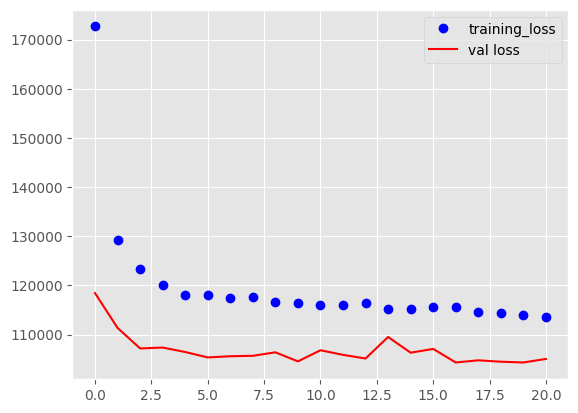

1047/1047 [==============================] - 1s 1ms/step
Test label :  [14 15 16 17 18 19 26 27 28 29 30 31 32 33 34 35 36 37 38 39  0  1  2  3
  4  5  6  7  8 11 12 13 20 21  9 10 22 23 24 25] size :  40
Y test clone/non clone :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3
 3 3 3]
Test data dimensions: (188, 5000), (188, 1)
188/188 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_identif:  273.89210123894736
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.09918097290210426
***************************************************************************************
xgb
***************************************************************************************
Time of xgb:  19.63597985706292
**************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2c5013a530>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:08:19
	Energy:	0.014620636294 kWh
	CO2eq:	6.944802239810 g
	This is equivalent to:
	0.064602811533 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2c5013aef0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	6:55:47
	Energy:	0.731031814717 kWh
	CO2eq:	347.240111990484 g
	This is equivalent to:
	3.230140576656 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1590959_2023-10-10T232157Z_carbontracker_output.log
St

In [8]:
model_choice = 'deep_auto_encoder_conv'
Tables_regression_results_Ano_identif = run_model_autoencoder('Anophele_identif', model_choice, part_anat = 'Pattes')

In [9]:
display(Tables_regression_results_Ano_identif)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.89,0.55,0.95,0.95,0.94,0.83,0.95,0.88,0.23,0.91
,"[0.85,0.94]","[0.49,0.63]","[0.93,0.98]","[0.93,0.98]","[0.91,0.97]","[0.79,0.88]","[0.93,0.98]","[0.84,0.93]","[0.18,0.29]","[0.87,0.95]"
Test balanced accuracy,0.84,0.32,0.90,0.90,0.88,0.76,0.90,0.84,0.30,0.88
,"[0.78,0.9]","[0.28,0.39]","[0.84,0.95]","[0.84,0.95]","[0.82,0.93]","[0.67,0.84]","[0.84,0.95]","[0.78,0.91]","[0.23,0.38]","[0.82,0.93]"
Mean F1 score,0.84,0.25,0.92,0.92,0.89,0.81,0.92,0.85,0.19,0.87
,"[0.78,0.9]","[0.22,0.3]","[0.86,0.97]","[0.86,0.97]","[0.83,0.95]","[0.73,0.87]","[0.86,0.96]","[0.79,0.91]","[0.14,0.27]","[0.82,0.93]"
F1 score by categories,"[0.97, 0.85, 1.0, 0.56]","[0.81, 0.03, 0.0, 0.19]","[1.0, 0.94, 1.0, 0.75]","[1.0, 0.94, 1.0, 0.75]","[0.99, 0.91, 0.95, 0.71]","[0.9, 0.73, 0.89, 0.73]","[1.0, 0.94, 1.0, 0.75]","[0.94, 0.86, 1.0, 0.63]","[0.0, 0.49, 0.13, 0.18]","[0.99, 0.88, 1.0, 0.64]"
Mean precision,0.84,0.45,0.97,0.97,0.94,0.89,0.97,0.87,0.19,0.87
,"[0.78,0.91]","[0.18,0.49]","[0.95,0.99]","[0.95,0.99]","[0.88,0.98]","[0.84,0.93]","[0.95,0.99]","[0.81,0.93]","[0.12,0.32]","[0.82,0.93]"


### Anopheles species identification : Head

2023-10-10 23:31:41.248681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5bf28412a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [37, 41, 42, 43, 45, 46, 47, 49, 50, 51, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 165, 166, 168, 169, 170, 171, 172, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 195, 197, 198, 199, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 0, 1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 52, 53, 54, 56, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 58, 59, 134, 60, 62, 63, 64, 67, 68, 69, 70, 72, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 159, 160, 162, 163, 164] size :  172
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

2023-10-10 23:31:49.234407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 23:31:50.445091: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5a6714b800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 23:31:50.445131: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 23:31:50.450823: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 23:31:50.544623: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


873/873 [==============================] - 20s 12ms/step - loss: 103423.0312 - val_loss: 79130.1328
Epoch 2/25
873/873 [==============================] - 9s 11ms/step - loss: 68782.3984 - val_loss: 71950.2891
Epoch 3/25
873/873 [==============================] - 9s 11ms/step - loss: 66011.1953 - val_loss: 69193.9062
Epoch 4/25
873/873 [==============================] - 9s 11ms/step - loss: 63134.8828 - val_loss: 69625.3906
Epoch 5/25
873/873 [==============================] - 9s 11ms/step - loss: 62111.6641 - val_loss: 65840.4297
Epoch 6/25
873/873 [==============================] - 9s 11ms/step - loss: 61103.9492 - val_loss: 64558.4844
Epoch 7/25
873/873 [==============================] - 9s 11ms/step - loss: 60846.9883 - val_loss: 64587.8672
Epoch 8/25
873/873 [==============================] - 9s 11ms/step - loss: 60571.2773 - val_loss: 64919.4531
Epoch 9/25
873/873 [==============================] - 9s 11ms/step - loss: 60015.4648 - val_loss: 63973.6445
Epoch 10/25
873/873 [=======

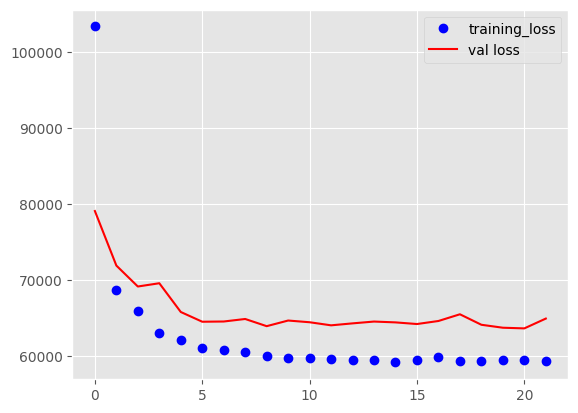

1089/1089 [==============================] - 1s 1ms/step
Test label :  [18 19 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45  0  1  2  3
  4  5  6  7  8  9 12 13 14 15 16 17 10 11 20 21 22 23 24 25 26 27] size :  46
Y test clone/non clone :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 3 3 3 3 3 3 3 3 3]
Test data dimensions: (214, 5000), (214, 1)
214/214 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_identif:  273.5262440040242
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.09989728895016015
***************************************************************************************
xgb
***************************************************************************************
Time of xgb:  18.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5ac87e1d50>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:08:51
	Energy:	0.015772361187 kWh
	CO2eq:	7.491871563605 g
	This is equivalent to:
	0.069691828499 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5ac87e1060>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	7:22:26
	Energy:	0.788618059327 kWh
	CO2eq:	374.593578180271 g
	This is equivalent to:
	3.484591424933 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1592561_2023-10-10T233141Z_carbontracker_output.log
St

In [7]:
model_choice = 'deep_auto_encoder_conv'
Tables_regression_results_Ano_identif = run_model_autoencoder('Anophele_identif', model_choice, part_anat = 'Tete')

In [8]:
display(Tables_regression_results_Ano_identif)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.78,0.39,0.80,0.84,0.84,0.50,0.88,0.73,0.27,0.71
,"[0.73,0.84]","[0.33,0.46]","[0.75,0.86]","[0.79,0.89]","[0.8,0.89]","[0.43,0.57]","[0.84,0.93]","[0.68,0.79]","[0.21,0.34]","[0.65,0.77]"
Test balanced accuracy,0.80,0.27,0.82,0.84,0.83,0.61,0.87,0.76,0.25,0.74
,"[0.76,0.85]","[0.26,0.3]","[0.78,0.87]","[0.8,0.89]","[0.79,0.88]","[0.57,0.67]","[0.83,0.91]","[0.72,0.81]","[0.2,0.3]","[0.7,0.79]"
Mean F1 score,0.80,0.17,0.83,0.85,0.84,0.52,0.88,0.76,0.17,0.73
,"[0.76,0.85]","[0.14,0.22]","[0.78,0.88]","[0.8,0.9]","[0.8,0.89]","[0.44,0.59]","[0.84,0.93]","[0.71,0.81]","[0.14,0.21]","[0.7,0.78]"
F1 score by categories,"[0.91, 0.71, 1.0, 0.6]","[0.57, 0.0, 0.0, 0.15]","[0.88, 0.74, 1.0, 0.72]","[0.94, 0.8, 1.0, 0.68]","[0.95, 0.81, 1.0, 0.62]","[0.69, 0.38, 0.65, 0.38]","[0.98, 0.86, 1.0, 0.71]","[0.92, 0.64, 1.0, 0.48]","[0.0, 0.38, 0.0, 0.32]","[0.97, 0.6, 1.0, 0.39]"
Mean precision,0.80,0.18,0.87,0.87,0.89,0.51,0.92,0.76,0.14,0.74
,"[0.76,0.86]","[0.12,0.27]","[0.84,0.91]","[0.83,0.92]","[0.85,0.93]","[0.44,0.59]","[0.88,0.95]","[0.71,0.81]","[0.11,0.18]","[0.7,0.79]"


### Anopheles species identification : Thorax

2023-10-10 23:45:21.872701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5778b227a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [34, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 109, 110, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 186, 187, 188, 191, 192, 193, 194, 195, 196, 197, 199, 200, 202, 0, 1, 3, 4, 8, 9, 11, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 50, 51, 52, 54, 55, 56, 73, 74, 75, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 111, 113, 114, 115, 116, 117, 118, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 141, 142, 143] size :  163
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

2023-10-10 23:45:29.745000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 23:45:31.003805: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f55ec3c2450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 23:45:31.003838: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 23:45:31.009162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 23:45:31.111681: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


819/819 [==============================] - 19s 12ms/step - loss: 235673.8125 - val_loss: 425722.4375
Epoch 2/25
819/819 [==============================] - 8s 10ms/step - loss: 212897.0938 - val_loss: 262631.7188
Epoch 3/25
819/819 [==============================] - 8s 10ms/step - loss: 129769.0781 - val_loss: 233720.7344
Epoch 4/25
819/819 [==============================] - 9s 11ms/step - loss: 127010.8594 - val_loss: 233679.4844
Epoch 5/25
819/819 [==============================] - 8s 10ms/step - loss: 125654.0000 - val_loss: 234275.7812
Epoch 6/25
819/819 [==============================] - 9s 11ms/step - loss: 125019.4609 - val_loss: 235972.3594
Epoch 7/25
819/819 [==============================] - 9s 11ms/step - loss: 124320.2422 - val_loss: 231849.3281
Epoch 8/25
819/819 [==============================] - 9s 11ms/step - loss: 124221.6172 - val_loss: 241025.7969
Epoch 9/25
819/819 [==============================] - 8s 10ms/step - loss: 123887.0391 - val_loss: 232677.8281
Epoch 10/25

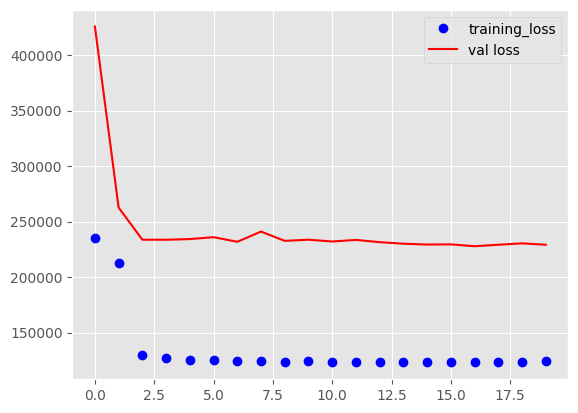

999/999 [==============================] - 1s 1ms/step
Test label :  [23 24 25 26 27 28 29 30 31 43 44 45 46 47 48 49 50 51 52 53  0  1  2  3
  4  5  6  7  8  9 10 14 15 16 17 18 19 20 21 22 32 11 12 13 33 34 35 36
 37 38 39 40 41 42] size :  54
Y test clone/non clone :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3]
Test data dimensions: (279, 5000), (279, 1)
279/279 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_identif:  184.93927257391624
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.11333884403575212
***************************************************************************************
xgb
*****************************************************************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f56701c11e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:08:50
	Energy:	0.014896444718 kWh
	CO2eq:	7.075811240940 g
	This is equivalent to:
	0.065821499916 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f56701c2050>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	7:21:16
	Energy:	0.744822235888 kWh
	CO2eq:	353.790562047023 g
	This is equivalent to:
	3.291074995786 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1594729_2023-10-10T234522Z_carbontracker_output.log
St

In [7]:
model_choice ='deep_auto_encoder_conv'
Tables_regression_results_Ano_identif = run_model_autoencoder('Anophele_identif', model_choice, part_anat = 'Thorax')

In [8]:
display(Tables_regression_results_Ano_identif)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.84,0.89,0.87,0.87,0.85,0.70,0.88,0.81,0.39,0.86
,"[0.8,0.89]","[0.85,0.93]","[0.83,0.91]","[0.84,0.91]","[0.81,0.9]","[0.65,0.75]","[0.85,0.92]","[0.77,0.86]","[0.34,0.46]","[0.82,0.9]"
Test balanced accuracy,0.85,0.87,0.86,0.87,0.83,0.61,0.86,0.82,0.39,0.84
,"[0.81,0.89]","[0.82,0.91]","[0.83,0.9]","[0.83,0.91]","[0.79,0.88]","[0.55,0.68]","[0.82,0.9]","[0.78,0.86]","[0.36,0.42]","[0.8,0.88]"
Mean F1 score,0.85,0.88,0.87,0.87,0.85,0.62,0.88,0.82,0.26,0.84
,"[0.81,0.89]","[0.85,0.92]","[0.84,0.91]","[0.84,0.92]","[0.81,0.89]","[0.55,0.69]","[0.84,0.92]","[0.78,0.87]","[0.23,0.29]","[0.81,0.89]"
F1 score by categories,"[0.93, 0.78, 1.0, 0.71]","[0.96, 0.87, 0.97, 0.74]","[0.91, 0.85, 1.0, 0.74]","[0.95, 0.84, 1.0, 0.73]","[0.91, 0.82, 0.97, 0.71]","[0.79, 0.66, 0.38, 0.67]","[0.94, 0.86, 0.97, 0.75]","[0.87, 0.8, 1.0, 0.64]","[0.0, 0.61, 0.0, 0.44]","[0.96, 0.84, 1.0, 0.61]"
Mean precision,0.85,0.91,0.90,0.89,0.88,0.66,0.91,0.83,0.21,0.86
,"[0.81,0.9]","[0.88,0.94]","[0.86,0.94]","[0.86,0.93]","[0.84,0.92]","[0.59,0.74]","[0.89,0.95]","[0.8,0.88]","[0.18,0.24]","[0.82,0.9]"


## Deep auto encoder fc

### MABS resistance detection

2023-10-10 09:28:46.195079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Train label :  [0, 2, 4, 5, 7, 8, 9, 11, 14, 16, 19, 21, 22, 23, 24, 25, 27, 28, 31, 3, 6, 10, 13, 15, 17, 30, 32] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Val label :  [18, 20, 26, 29, 1, 12] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 1, 1]
Train data dimensions: (648, 1, 5000), (648, 1)


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ffa39bf4520>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Validation data dimensions: (166, 1, 5000), (166, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5000)]         0         
                                                                 
 gaussian_dropout (Gaussian  (None, 1, 5000)           0         
 Dropout)                                                        
                                                      

2023-10-10 09:28:48.303742: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff903b2bed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 09:28:48.303781: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 09:28:48.309778: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 09:28:48.473225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 09:28:48.569272: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


648/648 [==============================] - 7s 8ms/step - loss: 6.1278e-05 - val_loss: 1.5324e-05
Epoch 2/25
648/648 [==============================] - 5s 8ms/step - loss: 1.9637e-05 - val_loss: 1.5259e-05
Epoch 3/25
648/648 [==============================] - 5s 8ms/step - loss: 1.6990e-05 - val_loss: 1.1736e-05
Epoch 4/25
648/648 [==============================] - 5s 8ms/step - loss: 1.4350e-05 - val_loss: 1.1844e-05
Epoch 5/25
648/648 [==============================] - 5s 8ms/step - loss: 1.3318e-05 - val_loss: 1.1524e-05
Epoch 6/25
648/648 [==============================] - 5s 8ms/step - loss: 1.2665e-05 - val_loss: 1.0936e-05
Epoch 7/25
648/648 [==============================] - 5s 8ms/step - loss: 1.1680e-05 - val_loss: 1.1068e-05
Epoch 8/25
648/648 [==============================] - 5s 8ms/step - loss: 1.1268e-05 - val_loss: 1.5446e-05
Epoch 9/25
648/648 [==============================] - 5s 8ms/step - loss: 1.0620e-05 - val_loss: 1.3242e-05
Epoch 10/25
648/648 [==================

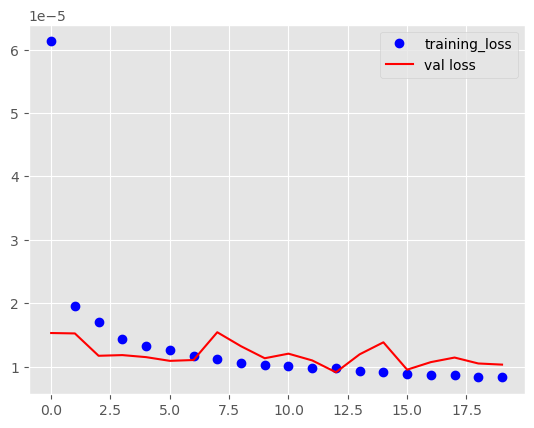

814/814 [==============================] - 1s 1ms/step
Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 1, 5000), (187, 1)
187/187 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of MABSC_coh:  146.57160012307577
***************************************************************************************
Algo ML :  knn
(187, 256)
***************************************************************************************
Time of knn:  0.32012401102110744
***************************************************************************************
Algo ML :  xgb
(187, 256)
***************************************************************************************
Time of xgb:  2.1116254850057885
***************************************************************************************
Algo ML :  ext
(187, 256)
********************************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ff983691420>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:05:03
	Energy:	0.012852914093 kWh
	CO2eq:	6.105134194077 g
	This is equivalent to:
	0.056791945991 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ff983691cf0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	4:12:51
	Energy:	0.642645704640 kWh
	CO2eq:	305.256709703836 g
	This is equivalent to:
	2.839597299571 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1411693_2023-10-10T092846Z_carbontracker_output.log
St

In [8]:
model_choice = 'deep_auto_encoder_fc'
Tables_regression_results_MABSC_coh_resistance = run_model_autoencoder('MABSC_coh_resistance', model_choice)

In [9]:
display(Tables_regression_results_MABSC_coh_resistance)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.65,0.80,0.66,0.73,0.87,0.60,0.79,0.75,0.75,0.79
,"[0.58,0.72]","[0.75,0.87]","[0.59,0.73]","[0.67,0.79]","[0.82,0.93]","[0.53,0.67]","[0.74,0.86]","[0.69,0.81]","[0.7,0.82]","[0.73,0.85]"
Test balanced accuracy,0.59,0.65,0.59,0.67,0.88,0.72,0.78,0.79,0.62,0.74
,"[0.51,0.68]","[0.59,0.73]","[0.51,0.67]","[0.6,0.75]","[0.82,0.93]","[0.67,0.77]","[0.72,0.86]","[0.73,0.85]","[0.55,0.69]","[0.67,0.82]"
Mean F1 score,0.57,0.68,0.58,0.66,0.84,0.59,0.75,0.72,0.63,0.73
,"[0.5,0.65]","[0.6,0.76]","[0.51,0.65]","[0.59,0.73]","[0.78,0.91]","[0.53,0.66]","[0.68,0.82]","[0.65,0.79]","[0.55,0.7]","[0.65,0.81]"
F1 score by categories,"[0.75, 0.4]","[0.88, 0.49]","[0.77, 0.4]","[0.82, 0.51]","[0.91, 0.79]","[0.65, 0.55]","[0.86, 0.65]","[0.81, 0.64]","[0.85, 0.42]","[0.86, 0.61]"
Mean precision,0.57,0.77,0.58,0.65,0.83,0.67,0.74,0.72,0.66,0.72
,"[0.51,0.65]","[0.68,0.87]","[0.51,0.65]","[0.58,0.73]","[0.76,0.89]","[0.63,0.73]","[0.67,0.81]","[0.66,0.79]","[0.57,0.76]","[0.65,0.8]"


### MABS subspecies identification

2023-10-10 09:36:52.904476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Train label :  [0, 1, 7, 12, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 4, 5, 14, 16, 3, 6, 8, 9, 13, 15, 18] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Val label :  [11, 22, 23, 29, 2, 10] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 2, 2]


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f8f394d5870>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train data dimensions: (680, 1, 5000), (680, 1)
Validation data dimensions: (134, 1, 5000), (134, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5000)]         0         
                                                                 
 gaussian_dropout (Gaussian  (None, 1, 5000)           0         
 Dropout)                                                        
      

2023-10-10 09:36:55.038896: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8e036c0c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 09:36:55.038936: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 09:36:55.045046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 09:36:55.219512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 09:36:55.316045: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


680/680 [==============================] - 8s 8ms/step - loss: 3.4515e-05 - val_loss: 3.4060e-05
Epoch 2/25
680/680 [==============================] - 5s 8ms/step - loss: 1.9235e-05 - val_loss: 3.0527e-05
Epoch 3/25
680/680 [==============================] - 5s 8ms/step - loss: 1.5819e-05 - val_loss: 2.9646e-05
Epoch 4/25
680/680 [==============================] - 5s 7ms/step - loss: 1.3119e-05 - val_loss: 3.2525e-05
Epoch 5/25
680/680 [==============================] - 5s 8ms/step - loss: 1.2225e-05 - val_loss: 3.2792e-05
Epoch 6/25
680/680 [==============================] - 5s 8ms/step - loss: 1.1584e-05 - val_loss: 2.6665e-05
Epoch 7/25
680/680 [==============================] - 5s 8ms/step - loss: 1.0964e-05 - val_loss: 2.7201e-05
Epoch 8/25
680/680 [==============================] - 5s 8ms/step - loss: 1.0075e-05 - val_loss: 2.6004e-05
Epoch 9/25
680/680 [==============================] - 5s 8ms/step - loss: 1.0188e-05 - val_loss: 2.5794e-05
Epoch 10/25
680/680 [==================

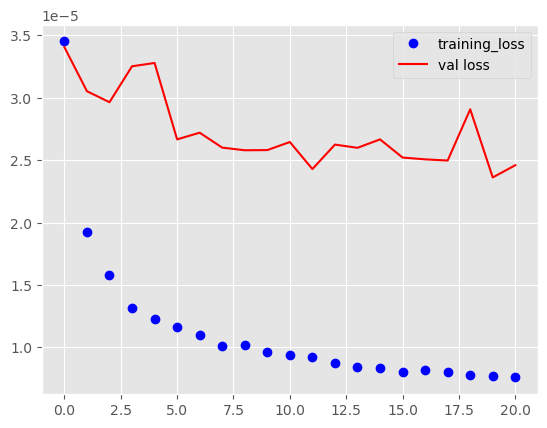

814/814 [==============================] - 1s 1ms/step
Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 1, 5000), (187, 1)
187/187 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of MABSC_coh:  116.64928857795894
***************************************************************************************
Algo ML :  knn
***************************************************************************************
Time of knn:  0.3538863300345838
***************************************************************************************
Algo ML :  xgb
***************************************************************************************
Time of xgb:  3.13299457996618
***************************************************************************************
Algo ML :  ext
********************************************************************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f8f39706f20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:04:58
	Energy:	0.013457369530 kWh
	CO2eq:	6.392250526718 g
	This is equivalent to:
	0.059462795597 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f8f39705ae0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	4:08:06
	Energy:	0.672868476497 kWh
	CO2eq:	319.612526335913 g
	This is equivalent to:
	2.973139779869 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1413133_2023-10-10T093653Z_carbontracker_output.log
St

In [8]:
model_choice = 'deep_auto_encoder_fc'
Tables_regression_results_MABSC_coh_espece = run_model_autoencoder('MABSC_coh_espece', model_choice)

In [9]:
display(Tables_regression_results_MABSC_coh_espece)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.74,0.73,0.74,0.74,0.74,0.68,0.74,0.75,0.63,0.73
,"[0.67,0.81]","[0.67,0.8]","[0.68,0.81]","[0.67,0.81]","[0.68,0.81]","[0.62,0.75]","[0.68,0.81]","[0.7,0.82]","[0.57,0.71]","[0.67,0.8]"
Test balanced accuracy,0.65,0.65,0.65,0.65,0.65,0.59,0.66,0.68,0.51,0.65
,"[0.64,0.67]","[0.62,0.69]","[0.64,0.67]","[0.64,0.67]","[0.64,0.67]","[0.55,0.63]","[0.67,0.67]","[0.67,0.7]","[0.46,0.56]","[0.63,0.67]"
Mean F1 score,0.57,0.58,0.59,0.59,0.59,0.54,0.60,0.63,0.49,0.59
,"[0.55,0.61]","[0.52,0.65]","[0.57,0.62]","[0.57,0.62]","[0.57,0.62]","[0.5,0.58]","[0.58,0.62]","[0.59,0.67]","[0.43,0.57]","[0.57,0.61]"
F1 score by categories,"[0.82, 0.0, 0.92]","[0.86, 0.12, 0.77]","[0.8, 0.0, 0.99]","[0.8, 0.0, 0.99]","[0.8, 0.0, 0.99]","[0.76, 0.0, 0.87]","[0.8, 0.0, 1.0]","[0.81, 0.08, 1.0]","[0.74, 0.12, 0.64]","[0.79, 0.0, 0.98]"
Mean precision,0.52,0.67,0.55,0.55,0.55,0.52,0.55,0.89,0.86,0.55
,"[0.48,0.56]","[0.47,0.84]","[0.53,0.58]","[0.53,0.58]","[0.53,0.58]","[0.49,0.56]","[0.53,0.58]","[0.55,0.92]","[0.53,0.89]","[0.53,0.58]"


### Anopheles age : Legs

2023-10-10 10:04:07.973676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200] size :  162
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ff3e9624e20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train data dimensions: (647, 1, 5000), (647, 1)
Validation data dimensions: (159, 1, 5000), (159, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
_________________________________________________________________
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5000)]         0         
                                                                 
 gaussian_dropout (Gaussian  (None, 1, 5000)           0         
 Dropout)                                                        
      

2023-10-10 10:04:10.079667: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff2b39cb6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 10:04:10.079707: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 10:04:10.086164: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 10:04:10.254041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 10:04:10.350260: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


647/647 [==============================] - 8s 8ms/step - loss: 7.6741e-05 - val_loss: 5.8854e-05
Epoch 2/25
647/647 [==============================] - 5s 8ms/step - loss: 5.2967e-05 - val_loss: 5.0849e-05
Epoch 3/25
647/647 [==============================] - 5s 8ms/step - loss: 4.5455e-05 - val_loss: 4.8275e-05
Epoch 4/25
647/647 [==============================] - 5s 8ms/step - loss: 4.1254e-05 - val_loss: 4.8042e-05
Epoch 5/25
647/647 [==============================] - 5s 8ms/step - loss: 3.7658e-05 - val_loss: 4.3490e-05
Epoch 6/25
647/647 [==============================] - 5s 8ms/step - loss: 3.5261e-05 - val_loss: 4.0987e-05
Epoch 7/25
647/647 [==============================] - 5s 8ms/step - loss: 3.2731e-05 - val_loss: 4.0960e-05
Epoch 8/25
647/647 [==============================] - 5s 8ms/step - loss: 3.1603e-05 - val_loss: 4.0177e-05
Epoch 9/25
647/647 [==============================] - 5s 8ms/step - loss: 3.0249e-05 - val_loss: 3.8546e-05
Epoch 10/25
647/647 [==================

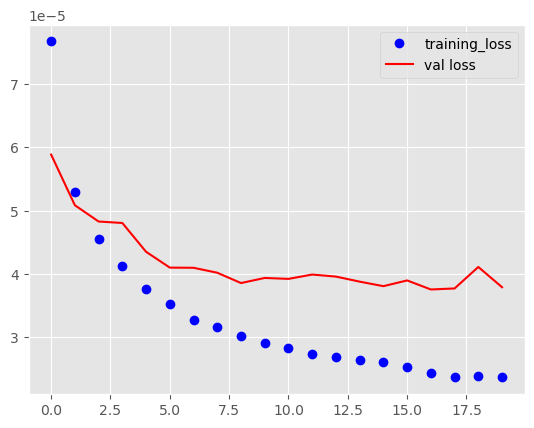

806/806 [==============================] - 1s 1ms/step
Non encode target
Test label :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] size :  36
Y test clone/non clone :  [ 0  0  3  3  3  3  3  6  6  8  8  8  8  8 10 10 10 10 15 17 17 17 17 17
 17 17 20 20 20 20 24 24 24 24 24 28]
Test data dimensions: (144, 1, 5000), (144, 1)
144/144 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_age:  106.33465869096108
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.09520615299697965
***************************************************************************************
xgb
***************************************************************************************
Time of xgb:  2

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ff3303c9510>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:03:03
	Energy:	0.008501776343 kWh
	CO2eq:	4.038343762832 g
	This is equivalent to:
	0.037565988491 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ff3303c9090>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	2:32:21
	Energy:	0.425088817140 kWh
	CO2eq:	201.917188141602 g
	This is equivalent to:
	1.878299424573 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1417773_2023-10-10T100408Z_carbontracker_output.log
St

In [11]:
model_choice = 'deep_auto_encoder_fc'
Tables_regression_results_Ano_age = run_model_autoencoder('Anophele_age', model_choice, part_anat = 'Pattes')

In [12]:
display(Tables_regression_results_Ano_age)

,knn,xgb,ext,rf,gbt,lgb,lnr
Metrics,,,,,,,
Test MAE,3.25,3.34,2.64,2.50,2.78,2.46,3.28
,"[2.85,3.7]","[2.93,3.74]","[2.33,2.97]","[2.23,2.8]","[2.48,3.1]","[2.15,2.77]","[2.96,3.62]"
Roc AUC score,0.86,0.87,0.92,0.92,0.91,0.92,0.89
,"[0.82,0.9]","[0.84,0.91]","[0.9,0.95]","[0.9,0.95]","[0.88,0.94]","[0.9,0.95]","[0.87,0.92]"
R2 score,0.70,0.72,0.82,0.84,0.81,0.84,0.75


### Anopheles age : Head

2023-10-10 10:15:14.726404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 75, 76, 77, 78, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 120, 121, 123, 124, 125, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 144, 145, 146, 147, 149, 151, 152, 153, 155, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182] size :  147
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd6a18feda0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Validation data dimensions: (144, 1, 5000), (144, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
_________________________________________________________________
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5000)]         0         
                                                                 
 gaussian_dropout (Gaussian  (None, 1, 5000)           0         
 Dropout)                                                        
                                                      

2023-10-10 10:15:16.823162: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd56b804640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 10:15:16.823203: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 10:15:16.829254: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 10:15:16.997109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 10:15:17.093348: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


583/583 [==============================] - 7s 8ms/step - loss: 8.1330e-05 - val_loss: 6.1740e-05
Epoch 2/25
583/583 [==============================] - 4s 8ms/step - loss: 5.6297e-05 - val_loss: 5.4943e-05
Epoch 3/25
583/583 [==============================] - 4s 8ms/step - loss: 4.7638e-05 - val_loss: 4.9335e-05
Epoch 4/25
583/583 [==============================] - 5s 8ms/step - loss: 4.3350e-05 - val_loss: 4.7554e-05
Epoch 5/25
583/583 [==============================] - 4s 8ms/step - loss: 3.9961e-05 - val_loss: 5.0644e-05
Epoch 6/25
583/583 [==============================] - 4s 8ms/step - loss: 3.6965e-05 - val_loss: 4.6328e-05
Epoch 7/25
583/583 [==============================] - 4s 8ms/step - loss: 3.5485e-05 - val_loss: 4.5424e-05
Epoch 8/25
583/583 [==============================] - 4s 8ms/step - loss: 3.4066e-05 - val_loss: 4.5136e-05
Epoch 9/25
583/583 [==============================] - 5s 8ms/step - loss: 3.2718e-05 - val_loss: 4.3741e-05
Epoch 10/25
583/583 [==================

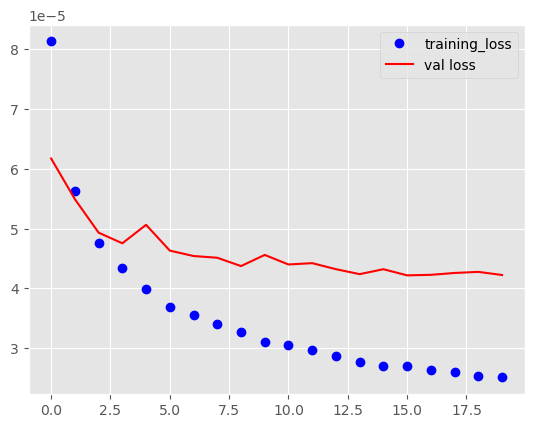

727/727 [==============================] - 1s 1ms/step
Non encode target
Test label :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31] size :  32
Y test clone/non clone :  [ 0  0  3  3  3  3  3  6  6  8  8  8  8  8 10 15 15 17 17 17 17 17 20 20
 20 20 24 24 24 24 28 28]
Test data dimensions: (124, 1, 5000), (124, 1)
124/124 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_age:  96.38952431397047
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.5733804031042382
***************************************************************************************
xgb
***************************************************************************************
Time of xgb:  2.40817121299915
**********

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd5dc207100>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:02:34
	Energy:	0.007400233390 kWh
	CO2eq:	3.515110860118 g
	This is equivalent to:
	0.032698705676 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd5dc206560>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	2:08:22
	Energy:	0.370011669486 kWh
	CO2eq:	175.755543005915 g
	This is equivalent to:
	1.634935283776 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1419299_2023-10-10T101515Z_carbontracker_output.log
St

In [8]:
model_choice = 'deep_auto_encoder_fc'
Tables_regression_results_Ano_age = run_model_autoencoder('Anophele_age', model_choice, part_anat = 'Tete')

In [9]:
display(Tables_regression_results_Ano_age)

,knn,xgb,ext,rf,gbt,lgb,lnr
Metrics,,,,,,,
Test MAE,2.97,3.56,3.39,3.69,3.31,3.52,2.93
,"[2.55,3.4]","[3.02,4.08]","[2.93,3.83]","[3.18,4.27]","[2.84,3.83]","[3.09,3.99]","[2.43,3.42]"
Roc AUC score,0.90,0.87,0.88,0.86,0.88,0.88,0.89
,"[0.88,0.94]","[0.83,0.91]","[0.85,0.92]","[0.82,0.91]","[0.85,0.92]","[0.84,0.91]","[0.86,0.92]"
R2 score,0.78,0.69,0.73,0.67,0.74,0.72,0.77


### Anopheles age : Thorax

2023-10-10 10:23:27.433237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Non encode target
Train label :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 29, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 78, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 103, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 133, 134, 135, 137, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 152, 153, 155, 156, 157, 159, 160, 161, 163, 164, 165, 166, 167, 169, 170, 172, 173, 174, 175, 176, 177, 178] size :  144
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 1

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9a8486c8e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Validation data dimensions: (129, 1, 5000), (129, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5000)]         0         
                                                                 
 gaussian_dropout (Gaussian  (None, 1, 5000)           0         
 Dropout)                                                        
                                                      

2023-10-10 10:23:29.527550: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f994f59d110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 10:23:29.527594: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 10:23:29.533804: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 10:23:29.701824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 10:23:29.799949: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


560/560 [==============================] - 7s 8ms/step - loss: 8.1784e-05 - val_loss: 6.5414e-05
Epoch 2/25
560/560 [==============================] - 4s 8ms/step - loss: 5.4703e-05 - val_loss: 5.7786e-05
Epoch 3/25
560/560 [==============================] - 4s 8ms/step - loss: 4.5604e-05 - val_loss: 5.2392e-05
Epoch 4/25
560/560 [==============================] - 4s 8ms/step - loss: 4.1038e-05 - val_loss: 5.1233e-05
Epoch 5/25
560/560 [==============================] - 4s 8ms/step - loss: 3.7241e-05 - val_loss: 4.9485e-05
Epoch 6/25
560/560 [==============================] - 4s 8ms/step - loss: 3.4054e-05 - val_loss: 4.7645e-05
Epoch 7/25
560/560 [==============================] - 4s 8ms/step - loss: 3.2303e-05 - val_loss: 4.6763e-05
Epoch 8/25
560/560 [==============================] - 4s 8ms/step - loss: 2.9942e-05 - val_loss: 4.6142e-05
Epoch 9/25
560/560 [==============================] - 4s 8ms/step - loss: 2.8623e-05 - val_loss: 4.5710e-05
Epoch 10/25
560/560 [==================

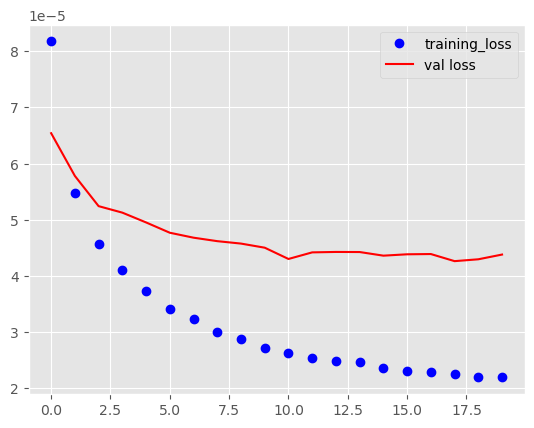

689/689 [==============================] - 1s 1ms/step
Non encode target
Test label :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] size :  31
Y test clone/non clone :  [ 0  0  3  3  3  3  3  6  6  6  8  8 10 10 15 15 15 17 17 17 20 20 20 20
 24 24 24 24 24 28 28]
Test data dimensions: (117, 1, 5000), (117, 1)
117/117 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_age:  92.84622835798655
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.09420764492824674
***************************************************************************************
xgb
***************************************************************************************
Time of xgb:  2.2352700730552897
*************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f99b7f45f30>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:02:25
	Energy:	0.006961701126 kWh
	CO2eq:	3.306808034920 g
	This is equivalent to:
	0.030761004976 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f99b7f47f70>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	2:01:12
	Energy:	0.348085056307 kWh
	CO2eq:	165.340401746010 g
	This is equivalent to:
	1.538050248800 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1421054_2023-10-10T102327Z_carbontracker_output.log
St

In [8]:
model_choice = 'deep_auto_encoder_fc'
Tables_regression_results_Ano_age = run_model_autoencoder('Anophele_age', model_choice, part_anat = 'Thorax')

In [9]:
display(Tables_regression_results_Ano_age)

,knn,xgb,ext,rf,gbt,lgb,lnr
Metrics,,,,,,,
Test MAE,2.26,3.23,2.25,2.96,2.67,3.07,2.78
,"[1.82,2.78]","[2.68,3.81]","[1.89,2.64]","[2.43,3.58]","[2.22,3.18]","[2.48,3.68]","[2.39,3.23]"
Roc AUC score,0.91,0.88,0.93,0.88,0.90,0.88,0.91
,"[0.88,0.95]","[0.85,0.91]","[0.9,0.96]","[0.85,0.92]","[0.88,0.94]","[0.85,0.92]","[0.89,0.94]"
R2 score,0.84,0.74,0.87,0.75,0.81,0.73,0.83


### Anopheles species identification : Legs

2023-10-10 10:51:28.631080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Train label :  [32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 114, 115, 116, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 193, 195, 196, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 48, 49, 50, 51, 52, 53, 55, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 117, 118, 119, 120, 121, 122, 123, 124, 57, 58, 0, 59, 60, 61, 62, 66, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 153, 154] size :  169
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f57badedc30>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train data dimensions: (825, 1, 5000), (825, 1)
Validation data dimensions: (222, 1, 5000), (222, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5000)]         0         
                                                                 
 gaussian_dropout (Gaussian  (None, 1, 5000)           0         
 Dropout)                                                        
      

2023-10-10 10:51:30.893416: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5683a4aef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 10:51:30.893458: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 10:51:30.899546: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 10:51:31.065624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 10:51:31.161985: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


825/825 [==============================] - 9s 8ms/step - loss: 7.6373e-05 - val_loss: 6.9902e-05
Epoch 2/25
825/825 [==============================] - 6s 8ms/step - loss: 5.2771e-05 - val_loss: 6.5177e-05
Epoch 3/25
825/825 [==============================] - 6s 8ms/step - loss: 4.3769e-05 - val_loss: 6.0666e-05
Epoch 4/25
825/825 [==============================] - 6s 8ms/step - loss: 3.9969e-05 - val_loss: 5.5949e-05
Epoch 5/25
825/825 [==============================] - 6s 8ms/step - loss: 3.6321e-05 - val_loss: 5.2751e-05
Epoch 6/25
825/825 [==============================] - 6s 8ms/step - loss: 3.2409e-05 - val_loss: 5.3337e-05
Epoch 7/25
825/825 [==============================] - 6s 8ms/step - loss: 3.0670e-05 - val_loss: 5.3157e-05
Epoch 8/25
825/825 [==============================] - 6s 8ms/step - loss: 3.0011e-05 - val_loss: 4.9747e-05
Epoch 9/25
825/825 [==============================] - 6s 8ms/step - loss: 2.8998e-05 - val_loss: 5.1015e-05
Epoch 10/25
825/825 [==================

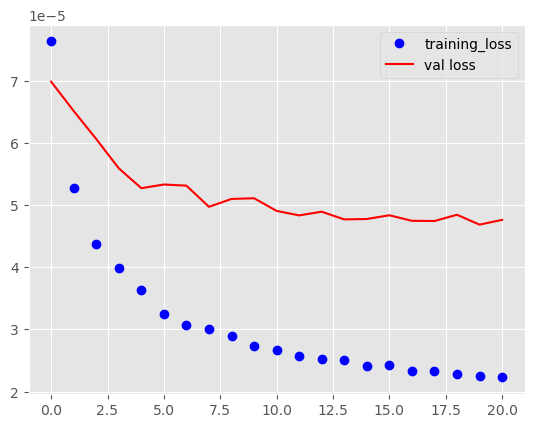

1047/1047 [==============================] - 1s 1ms/step
Test label :  [14 15 16 17 18 19 26 27 28 29 30 31 32 33 34 35 36 37 38 39  0  1  2  3
  4  5  6  7  8 11 12 13 20 21  9 10 22 23 24 25] size :  40
Y test clone/non clone :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3
 3 3 3]
Test data dimensions: (188, 1, 5000), (188, 1)
188/188 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_identif:  139.400501910015
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.09493738901801407
***************************************************************************************
xgb
***************************************************************************************
Time of xgb:  6.111588827101514
*************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f57badedd50>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:05:13
	Energy:	0.014817249086 kWh
	CO2eq:	7.038193315666 g
	This is equivalent to:
	0.065471565727 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f57badee8f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	4:20:50
	Energy:	0.740862454281 kWh
	CO2eq:	351.909665783302 g
	This is equivalent to:
	3.273578286356 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1425615_2023-10-10T105129Z_carbontracker_output.log
St

In [10]:
model_choice = 'deep_auto_encoder_fc'
Tables_regression_results_Ano_identif = run_model_autoencoder('Anophele_identif', model_choice, part_anat = 'Pattes')

In [11]:
display(Tables_regression_results_Ano_identif)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.88,0.52,0.95,0.93,0.96,0.71,0.95,0.93,0.81,0.95
,"[0.85,0.93]","[0.45,0.59]","[0.92,0.98]","[0.9,0.97]","[0.94,0.99]","[0.65,0.78]","[0.93,0.98]","[0.9,0.97]","[0.77,0.87]","[0.92,0.98]"
Test balanced accuracy,0.86,0.25,0.93,0.91,0.95,0.65,0.93,0.91,0.48,0.89
,"[0.8,0.92]","[0.25,0.25]","[0.89,0.98]","[0.87,0.97]","[0.9,0.99]","[0.55,0.75]","[0.88,0.98]","[0.86,0.96]","[0.46,0.5]","[0.84,0.95]"
Mean F1 score,0.85,0.18,0.93,0.91,0.95,0.66,0.94,0.92,0.44,0.91
,"[0.79,0.91]","[0.17,0.2]","[0.89,0.97]","[0.86,0.95]","[0.92,0.99]","[0.57,0.74]","[0.89,0.98]","[0.88,0.96]","[0.42,0.46]","[0.85,0.96]"
F1 score by categories,"[0.96, 0.85, 1.0, 0.59]","[0.73, 0.0, 0.0, 0.0]","[0.98, 0.94, 1.0, 0.82]","[0.99, 0.91, 1.0, 0.74]","[0.98, 0.96, 1.0, 0.89]","[0.8, 0.85, 0.75, 0.27]","[0.98, 0.94, 1.0, 0.84]","[0.97, 0.9, 1.0, 0.84]","[0.92, 0.84, 0.0, 0.0]","[1.0, 0.93, 1.0, 0.73]"
Mean precision,0.84,0.14,0.93,0.90,0.96,0.73,0.95,0.93,0.40,0.95
,"[0.79,0.9]","[0.12,0.16]","[0.89,0.98]","[0.85,0.95]","[0.93,0.99]","[0.7,0.78]","[0.9,0.98]","[0.89,0.97]","[0.38,0.43]","[0.9,0.98]"


### Anopheles species identification : Head

2023-10-10 10:57:49.235608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Train label :  [37, 41, 42, 43, 45, 46, 47, 49, 50, 51, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 165, 166, 168, 169, 170, 171, 172, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 195, 197, 198, 199, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 0, 1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 52, 53, 54, 56, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 58, 59, 134, 60, 62, 63, 64, 67, 68, 69, 70, 72, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 159, 160, 162, 163, 164] size :  172
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5c134835e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train data dimensions: (873, 1, 5000), (873, 1)
Validation data dimensions: (216, 1, 5000), (216, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5000)]         0         
                                                                 
 gaussian_dropout (Gaussian  (None, 1, 5000)           0         
 Dropout)                                                        
      

2023-10-10 10:57:51.483905: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5adb92f6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 10:57:51.483942: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 10:57:51.490010: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 10:57:51.659435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 10:57:51.755777: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


873/873 [==============================] - 9s 8ms/step - loss: 7.8717e-05 - val_loss: 6.6827e-05
Epoch 2/25
873/873 [==============================] - 7s 8ms/step - loss: 5.1903e-05 - val_loss: 5.6513e-05
Epoch 3/25
873/873 [==============================] - 7s 8ms/step - loss: 4.4754e-05 - val_loss: 5.2800e-05
Epoch 4/25
873/873 [==============================] - 7s 8ms/step - loss: 3.8933e-05 - val_loss: 4.9492e-05
Epoch 5/25
873/873 [==============================] - 7s 8ms/step - loss: 3.5811e-05 - val_loss: 4.8471e-05
Epoch 6/25
873/873 [==============================] - 7s 8ms/step - loss: 3.3847e-05 - val_loss: 4.8264e-05
Epoch 7/25
873/873 [==============================] - 7s 8ms/step - loss: 3.2604e-05 - val_loss: 4.4668e-05
Epoch 8/25
873/873 [==============================] - 7s 8ms/step - loss: 3.0967e-05 - val_loss: 4.3988e-05
Epoch 9/25
873/873 [==============================] - 7s 8ms/step - loss: 2.9320e-05 - val_loss: 4.5237e-05
Epoch 10/25
873/873 [==================

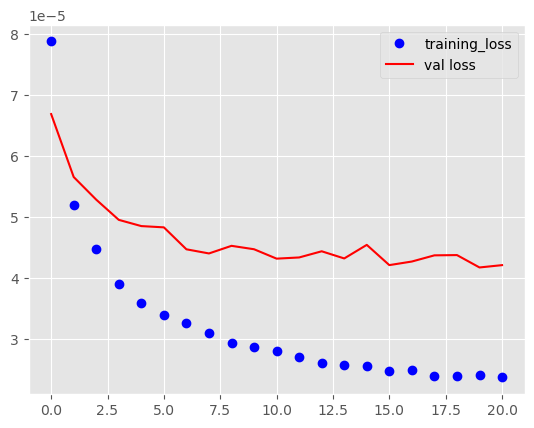

1089/1089 [==============================] - 1s 1ms/step
Test label :  [18 19 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45  0  1  2  3
  4  5  6  7  8  9 12 13 14 15 16 17 10 11 20 21 22 23 24 25 26 27] size :  46
Y test clone/non clone :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 3 3 3 3 3 3 3 3 3]
Test data dimensions: (214, 1, 5000), (214, 1)
214/214 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_identif:  146.30250411003362
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.09401801601052284
***************************************************************************************
xgb
***************************************************************************************
Time of xgb: 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5c13481870>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:06:00
	Energy:	0.016430523580 kWh
	CO2eq:	7.804498700404 g
	This is equivalent to:
	0.072599987911 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5c13480460>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	4:59:38
	Energy:	0.821526178990 kWh
	CO2eq:	390.224935020197 g
	This is equivalent to:
	3.629999395537 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1426716_2023-10-10T105749Z_carbontracker_output.log
St

In [7]:
model_choice = 'deep_auto_encoder_fc'
Tables_regression_results_Ano_identif = run_model_autoencoder('Anophele_identif', model_choice, part_anat = 'Tete')

In [8]:
display(Tables_regression_results_Ano_identif)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.82,0.37,0.80,0.81,0.75,0.60,0.78,0.83,0.78,0.78
,"[0.77,0.87]","[0.31,0.44]","[0.75,0.86]","[0.76,0.86]","[0.7,0.81]","[0.54,0.67]","[0.73,0.84]","[0.79,0.88]","[0.74,0.85]","[0.73,0.84]"
Test balanced accuracy,0.83,0.25,0.82,0.82,0.78,0.60,0.80,0.84,0.58,0.80
,"[0.79,0.87]","[0.25,0.25]","[0.78,0.87]","[0.78,0.87]","[0.74,0.83]","[0.51,0.69]","[0.76,0.85]","[0.8,0.89]","[0.54,0.63]","[0.76,0.85]"
Mean F1 score,0.83,0.14,0.82,0.82,0.78,0.61,0.80,0.84,0.58,0.80
,"[0.79,0.87]","[0.13,0.16]","[0.77,0.86]","[0.78,0.87]","[0.73,0.83]","[0.52,0.68]","[0.76,0.85]","[0.8,0.89]","[0.54,0.63]","[0.76,0.85]"
F1 score by categories,"[0.95, 0.77, 1.0, 0.62]","[0.57, 0.0, 0.0, 0.0]","[0.97, 0.74, 1.0, 0.57]","[0.93, 0.75, 1.0, 0.63]","[0.9, 0.66, 1.0, 0.57]","[0.92, 0.37, 0.75, 0.41]","[0.94, 0.7, 1.0, 0.57]","[0.98, 0.79, 1.0, 0.61]","[0.93, 0.76, 0.0, 0.66]","[0.92, 0.71, 1.0, 0.6]"
Mean precision,0.83,0.10,0.81,0.83,0.78,0.68,0.80,0.84,0.61,0.80
,"[0.79,0.88]","[0.08,0.12]","[0.77,0.87]","[0.79,0.88]","[0.73,0.84]","[0.64,0.73]","[0.76,0.85]","[0.8,0.89]","[0.57,0.66]","[0.76,0.86]"


### Anopheles species identification : Thorax

2023-10-10 22:12:19.061145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Train label :  [34, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 109, 110, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 186, 187, 188, 191, 192, 193, 194, 195, 196, 197, 199, 200, 202, 0, 1, 3, 4, 8, 9, 11, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 50, 51, 52, 54, 55, 56, 73, 74, 75, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 111, 113, 114, 115, 116, 117, 118, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 141, 142, 143] size :  163
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc03590e410>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train data dimensions: (819, 1, 5000), (819, 1)
Validation data dimensions: (180, 1, 5000), (180, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5000)]         0         
                                                                 
 gaussian_dropout (Gaussian  (None, 1, 5000)           0         
 Dropout)                                                        
      

2023-10-10 22:12:21.253280: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbeff822100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 22:12:21.253322: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-10 22:12:21.259860: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 22:12:21.426467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-10 22:12:21.522913: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


819/819 [==============================] - 9s 8ms/step - loss: 7.7233e-05 - val_loss: 7.4012e-05
Epoch 2/25
819/819 [==============================] - 6s 8ms/step - loss: 5.2190e-05 - val_loss: 6.3995e-05
Epoch 3/25
819/819 [==============================] - 6s 8ms/step - loss: 4.2016e-05 - val_loss: 5.8476e-05
Epoch 4/25
819/819 [==============================] - 6s 8ms/step - loss: 3.7161e-05 - val_loss: 5.5734e-05
Epoch 5/25
819/819 [==============================] - 6s 8ms/step - loss: 3.4259e-05 - val_loss: 5.2889e-05
Epoch 6/25
819/819 [==============================] - 6s 8ms/step - loss: 3.0972e-05 - val_loss: 5.2434e-05
Epoch 7/25
819/819 [==============================] - 6s 8ms/step - loss: 2.9598e-05 - val_loss: 5.1059e-05
Epoch 8/25
819/819 [==============================] - 6s 8ms/step - loss: 2.7114e-05 - val_loss: 5.0740e-05
Epoch 9/25
819/819 [==============================] - 6s 8ms/step - loss: 2.6264e-05 - val_loss: 4.8544e-05
Epoch 10/25
819/819 [==================

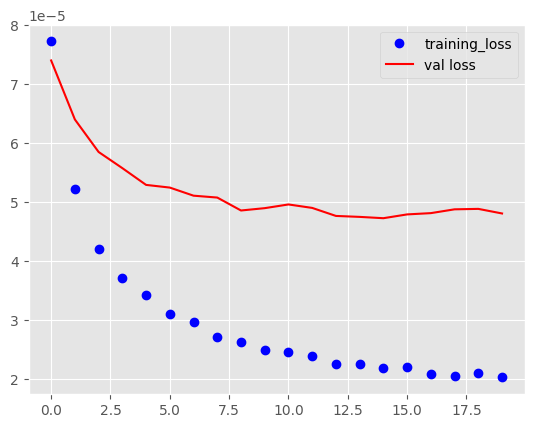

999/999 [==============================] - 1s 1ms/step
Test label :  [23 24 25 26 27 28 29 30 31 43 44 45 46 47 48 49 50 51 52 53  0  1  2  3
  4  5  6  7  8  9 10 14 15 16 17 18 19 20 21 22 32 11 12 13 33 34 35 36
 37 38 39 40 41 42] size :  54
Y test clone/non clone :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3]
Test data dimensions: (279, 1, 5000), (279, 1)
279/279 [==============================] - 0s 1ms/step
***************************************************************************************
Time auto encoder of Anophele_identif:  132.85284040903207
***************************************************************************************
knn
***************************************************************************************
Time of knn:  0.09570107702165842
***************************************************************************************
xgb
**************************************************************

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fbf56fc88e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


#################################################################################################################
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Average carbon intensity during training was 475.00 gCO2/kWh at detected location: UNDETECTED.
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:07:23
	Energy:	0.016352433569 kWh
	CO2eq:	7.767405945284 g
	This is equivalent to:
	0.072254939026 km travelled by car


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fbf56fcba60>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	6:09:14
	Energy:	0.817621678451 kWh
	CO2eq:	388.370297264205 g
	This is equivalent to:
	3.612746951295 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1579063_2023-10-10T221219Z_carbontracker_output.log
St

In [7]:
model_choice = 'deep_auto_encoder_fc'
Tables_regression_results_Ano_identif = run_model_autoencoder('Anophele_identif', model_choice, part_anat = 'Thorax')


In [8]:
display(Tables_regression_results_Ano_identif)

,knn,xgb,ext,rf,gbt,gnb,lgb,lda,qda,svc
Metrics,,,,,,,,,,
Test accuracy,0.91,0.39,0.87,0.86,0.87,0.71,0.90,0.91,0.73,0.85
,"[0.89,0.95]","[0.33,0.45]","[0.83,0.91]","[0.82,0.9]","[0.83,0.91]","[0.66,0.77]","[0.87,0.94]","[0.88,0.94]","[0.68,0.79]","[0.81,0.89]"
Test balanced accuracy,0.91,0.24,0.86,0.86,0.88,0.56,0.91,0.90,0.55,0.85
,"[0.88,0.95]","[0.24,0.25]","[0.83,0.91]","[0.82,0.9]","[0.84,0.92]","[0.51,0.63]","[0.87,0.94]","[0.87,0.94]","[0.51,0.59]","[0.81,0.89]"
Mean F1 score,0.91,0.14,0.88,0.87,0.89,0.57,0.92,0.91,0.54,0.87
,"[0.88,0.95]","[0.13,0.16]","[0.84,0.92]","[0.83,0.91]","[0.86,0.92]","[0.5,0.65]","[0.89,0.95]","[0.88,0.94]","[0.5,0.59]","[0.83,0.9]"
F1 score by categories,"[0.95, 0.92, 1.0, 0.8]","[0.6, 0.0, 0.0, 0.0]","[0.89, 0.87, 1.0, 0.76]","[0.87, 0.86, 1.0, 0.77]","[0.86, 0.88, 1.0, 0.83]","[0.84, 0.66, 0.18, 0.62]","[0.9, 0.92, 1.0, 0.86]","[0.97, 0.88, 1.0, 0.81]","[0.82, 0.74, 0.0, 0.62]","[0.87, 0.83, 1.0, 0.78]"
Mean precision,0.91,0.10,0.91,0.90,0.91,0.77,0.93,0.92,0.58,0.91
,"[0.89,0.95]","[0.09,0.12]","[0.88,0.95]","[0.87,0.94]","[0.88,0.94]","[0.5,0.81]","[0.91,0.96]","[0.89,0.95]","[0.54,0.62]","[0.9,0.94]"
